<a href="https://colab.research.google.com/github/navneetkrc/Colab_fastai/blob/master/fast_ai_movie_review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

In [0]:
from fastai import *
from fastai.text import * 
from fastai.gen_doc.nbdoc import *
from fastai.datasets import * 
from fastai.datasets import Config
from pathlib import Path
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


In [0]:
#import fastai; 
#fastai.show_install(1)

In [0]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!mkdir -p input
!echo '{"username":"username","key":"XXxxxxxxxxxxxxxx"}'> ~/.kaggle/kaggle.json  # Replace
#!chmod 600 kaggle.json


In [0]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

In [0]:
!unzip test.tsv.zip -d input
!unzip train.tsv.zip -d input
!mv sampleSubmission.csv input/

In [0]:
path = Path('../input/')
path_working = Path('kaggle/')

In [9]:
df = pd.read_csv('input/train.tsv', sep="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [10]:
df['is_valid'] = 0
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,is_valid
0,1,1,A series of escapades demonstrating the adage ...,1,0
1,2,1,A series of escapades demonstrating the adage ...,2,0
2,3,1,A series,2,0
3,4,1,A,2,0
4,5,1,series,2,0


In [11]:
df.loc[:50, 'is_valid'] = 1
df.head()

,PhraseId,SentenceId,Phrase,Sentiment,is_valid
0,1,1,A series of escapades demonstrating the adage ...,1,1
1,2,1,A series of escapades demonstrating the adage ...,2,1
2,3,1,A series,2,1
3,4,1,A,2,1
4,5,1,series,2,1


In [12]:
df_test = pd.read_csv('input/test.tsv', sep="\t")
df_test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [0]:
df.rename(index=str, columns={"Phrase": "text", "Sentiment": "target"},inplace=True)

In [0]:
df_test.rename(index=str, columns={"Phrase": "text", "Sentiment": "target"},inplace=True)

In [0]:
df_test['is_valid'] = 0

In [0]:
df_test.to_csv(f'test.csv', index=False)

In [0]:
df.to_csv(f'train.csv', index=False)

In [0]:
!mkdir kaggle
!mv train.csv kaggle/
!mv test.csv kaggle/

In [19]:
df_mod = pd.read_csv('kaggle/train.csv')
df_mod.head()

,PhraseId,SentenceId,text,target,is_valid
0,1,1,A series of escapades demonstrating the adage ...,1,1
1,2,1,A series of escapades demonstrating the adage ...,2,1
2,3,1,A series,2,1
3,4,1,A,2,1
4,5,1,series,2,1


In [20]:
path_working

PosixPath('kaggle')

In [0]:
data_lm = (TextList.from_csv(path_working, 'train.csv', cols='text') 
                   .random_split_by_pct()
                   .label_for_lm()
                   .add_test(TextList.from_csv(path_working, 'test.csv', cols='text'))
                   .databunch())

In [22]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)
#learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.7)
learn.model

SequentialRNN(
  (0): RNNCore(
    (encoder): Embedding(15107, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(15107, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=15107, bias=True)
    (output_dp): RNNDropout()
  )
)

In [0]:
learn.lr_find()

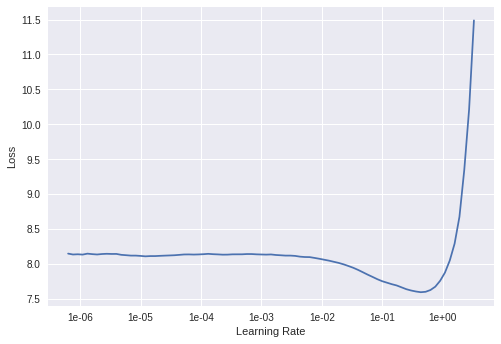

In [37]:
learn.recorder.plot()

In [42]:
learn.fit_one_cycle(2, 1e-2)
learn.save('mini_train_lm')
learn.save_encoder('mini_train_encoder')

epoch,train_loss,valid_loss,accuracy
1,5.838126,5.176986,0.211350
2,5.104383,4.504126,0.254440


In [0]:
#load the encoder models in models folder
!mkdir kaggle/models
!mv mini_train_encoder.pth kaggle/models/
!mv mini_train_lm.pth kaggle/models/

In [0]:
#learn.load_encoder('ft_enc53')
learn.load_encoder('mini_train_encoder')

In [43]:
learn.show_results()

text,target,pred
"xxbos , there is n't much there here . xxbos suspect that you 'll be as bored watching xxmaj morvern","callar as the characters are in it xxbos is a desperate miscalculation . xxbos xxmaj argento , xxbos its paint",romanek japanimator weakness protagonists respond framed neutral center zeus impossible pianist achievement testosterone sputters certified australia baker overmanipulative android unerring
told as the truth xxbos color schemes xxbos with enjoyable performances xxbos all the emotions xxbos xxmaj boasts eye -,"art direction but has a forcefully quirky tone that quickly wears out its limited welcome . xxbos authentically vague ,",twelve press videos permits savaged monopoly ring butler ethical bespeaks introduces 80 winningly pulpy drastic spouting liang fessenden faulted verdu
visible xxbos to an act of cinematic penance xxbos brought off with considerable wit xxbos xxup p.c. than the original,"xxup -lrb- no more racist portraits of xxmaj indians , for instance xxup -rrb- xxbos a must - own xxbos",struggled dvd 1999 embellishment unmentionable portraits mob varying california majidi someplace instance verismo -rrb- roughshod economic stumblebum sleep see radical
xxmaj toy xxmaj story 2 xxbos of the elements that will grab you xxbos a muddle xxbos in a heartwarming,nonjudgmental kind of way -- xxbos may rate as the most magical and most fun family fare of this or,brutally imagines rap unity heartedness nonexistent winged inadvertently distasteful valid chatter admirable comment accept complexly fondly quadrangle gidget 2002 year
adaptation xxbos about modern man xxbos into rap xxbos takes an abrupt turn xxbos provide a reason for us xxbos,"in spite of all that he 's witnessed , remains surprisingly idealistic xxbos the filmmakers just follow the books xxbos",lecherous 1899 shore rural cylinders malarkey demonstrates witnessed findings trilogy unwatchable idealistic sharpener crikey turmoil behave fell your emigre responsible


In [0]:
#??TextList.from_csv

In [0]:
data_clas = (TextList.from_csv(path_working, 'train.csv',cols='text', vocab=data_lm.vocab, test='test')
    .split_from_df(col='is_valid') #is_valid
    .label_from_df(cols='target')
    .add_test(TextList.from_csv(path_working, 'test.csv', cols='text'))
    .databunch(bs=42))

In [45]:
type(data_clas.test_dl)

fastai.basic_data.DeviceDataLoader

In [46]:
data_clas.show_batch()

text,target
"xxbos xxup -lrb- xxmaj city xxup -rrb- reminds us how realistically nuanced a xxmaj robert xxmaj de xxmaj niro performance can be when he is not more lucratively engaged in the shameless self - caricature of ` xxmaj analyze xxmaj this ' xxup -lrb- 1999 xxup -rrb- and ` xxmaj analyze xxmaj that , ' promised xxup -lrb- or threatened xxup -rrb- for later this year .",3
"xxbos xxmaj as predictable as the outcome of a xxmaj globetrotters - xxmaj generals game , xxmaj juwanna xxmaj mann is even more ludicrous than you 'd expect from the guy - in - a - dress genre , and a personal low for everyone involved .",0
"xxbos xxmaj city by the xxmaj sea swings from one approach to the other , but in the end , it stays in formula -- which is a waste of xxmaj de xxmaj niro , mcdormand and the other good actors in the cast .",1
"xxbos xxmaj any intellectual arguments being made about the nature of xxmaj god are framed in a drama so clumsy , there is a real danger less sophisticated audiences will mistake it for an endorsement of the very things that xxmaj bean abhors .",2
"xxbos felt ; not the xxmaj craven of ' a xxmaj nightmare on xxmaj elm xxmaj street ' or ` xxmaj the xxmaj hills xxmaj have xxmaj eyes , ' but the sad schlock merchant of ` xxmaj deadly xxmaj friend",1


In [0]:
#??text_classifier_learner()

In [47]:
data_clas.c

5

In [0]:
#len(data_clas.vocab.itos)

In [49]:
learn = text_classifier_learner(data_clas, model_dir="/tmp/model/")
learn.model

SequentialRNN(
  (0): MultiBatchRNNCore(
    (encoder): Embedding(15088, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(15088, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.4)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace)
      (4): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): Dropout(p=0.1)
  

In [0]:
#learn.crit = F.binary_cross_entropy
learn.crit = F.binary_cross_entropy_with_logits

In [0]:
learn.load_encoder('mini_train_encoder')
learn.fit_one_cycle(5, slice(1e-3,1e-2))
learn.save('mini_train_clas')

In [54]:
# get predictions
preds, targets = learn.get_preds()

predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,1,2,3
row_0,,,
2,4,44,3


In [55]:
learn.show_results()

text,target,prediction
"xxbos a series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,2
"xxbos is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",2,2
"xxbos is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story",2,2
"xxbos good for the gander , some of which occasionally amuses but none of which amounts to much of a story",2,2
"xxbos for the gander , some of which occasionally amuses but none of which amounts to much of a story",2,2


In [56]:
probs = np.mean(np.exp(log_preds),0)

preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

plot_confusion_matrix(cm, data.classes)

NameError: ignored

In [0]:
# Language model data
#data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "")

# Classifier model data
#data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)

In [0]:
#type(learn.data.test_dl)

In [0]:
probs, _ = learn.get_preds(DatasetType.Test)

In [0]:
probs.shape

In [52]:
probs[0]

NameError: ignored

In [53]:
preds = np.argmax(probs, axis=1)

NameError: ignored

In [0]:
ids = df_test["PhraseId"].copy()

In [0]:
submission = pd.DataFrame(data={
    "PhraseId": ids,
    "Sentiment": preds
})
submission.to_csv("submission.csv", index=False)
submission.head(n=10)

In [0]:
#df.head()

In [0]:
#from sklearn.model_selection import train_test_split

# split data into training and validation set
#df_trn, df_val = train_test_split(df, stratify = df['target'], test_size = 0.4, random_state = 12)

In [0]:
# Language model data
#data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = "../input")


In [0]:

# Classifier model data
#data_clas = TextClasDataBunch.from_df(path = "", train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=32)